In [1]:
import os
import math
import sys
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import re
from functools import reduce
from operator import and_
import yfinance as yf
from functools import partial, reduce                                                                              
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import datetime as dt
from pdb import set_trace as keyboard
import xlrd
from xlrd import open_workbook
from sklearn.decomposition import FastICA
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
from tkinter import StringVar
import matplotlib.pyplot as plt
from sklearn import linear_model
clf = linear_model.LinearRegression()

import matplotlib

yf.pdr_override()

In [2]:
stockIndex = ['IBOV']
sectorIndexes = ['ICON', 'IEE', 'IFNC', 'IMAT', 'IMOB', 'INDX', 'UTIL']
currencies = ['DOLAR']

In [3]:
ltnExcelFile = 'assets\LTN.xls'
xl_ltn = pd.ExcelFile(ltnExcelFile)

ltn_dict = {}
for bond in xl_ltn.sheet_names:
    df = pd.read_excel(ltnExcelFile, sheet_name=bond, skiprows = 1, usecols='A, E', names=['Date', 'Value'],
                          index_col=0).pct_change()
    df.columns = [bond]
    ltn_dict[bond] = df
    
my_reduce = partial(pd.merge, on='Date', how='outer')                                                              
ltn_df = reduce(my_reduce, ltn_dict.values()) 
ltn_df.head()

,LTN 010120,LTN 010121,LTN 010122,LTN 010123,LTN 010125
Date,,,,,
02/01/2019,NaN,NaN,NaN,NaN,NaN
03/01/2019,0.001002,0.002885,NaN,0.005116,0.005291
04/01/2019,-0.000213,-0.001197,NaN,-0.002614,-0.003481
07/01/2019,0.000341,0.000276,NaN,0.001789,0.005839
08/01/2019,-0.000394,-0.001186,NaN,-0.000401,-0.000201


In [4]:
ntnbExcelFile = 'assets\\NTNB.xls'
xl_ntnb = pd.ExcelFile(ntnbExcelFile)

ntnb_dict = {}
for bond in xl_ntnb.sheet_names:
    df = pd.read_excel(ntnbExcelFile, sheet_name=bond, skiprows = 1, usecols='A, E', names=['Date', 'Value'],
                          index_col=0).pct_change()
    df.columns = [bond]
    ntnb_dict[bond] = df
                                                               
ntnb_df = reduce(my_reduce, ntnb_dict.values()) 
ntnb_df.head()

,NTN-B Princ 150519,NTN-B Princ 150824,NTN-B Princ 150535,NTN-B Princ 150545
Date,,,,
02/01/2019,NaN,NaN,NaN,NaN
03/01/2019,0.000557,0.003426,0.000227,0.000232
04/01/2019,0.000713,0.001878,-0.004357,-0.007193
07/01/2019,0.000268,0.002882,0.020613,0.033289
08/01/2019,0.000131,0.000743,0.008024,0.012823


In [5]:
remaining_dict = {}
for data in sectorIndexes + currencies:
    df = pd.read_excel(r"C:\Users\Faria\Desktop\Gerador\%s.xlsx" % data, usecols='D, F', index_col=0, 
                       names=['Date', 'Value'])
    df.columns = [data]
    remaining_dict[data] = df

remaining_df = reduce(my_reduce, remaining_dict.values()) 
remaining_df.head()

,ICON,IEE,IFNC,IMAT,IMOB,INDX,UTIL,DOLAR
Date,,,,,,,,
20/09/2019,0.006721,-0.010145,0.008868,-0.003893,0.007486,0.008298,-0.015636,0.007103
19/09/2019,0.008921,0.010532,-0.010924,-0.008233,0.024046,-0.001264,0.009156,0.010275
18/09/2019,0.000290,0.000352,0.007111,-0.003744,0.005900,-0.001089,-0.000012,-0.000634
17/09/2019,0.010354,0.008720,0.016281,0.005897,0.031984,0.008853,0.008223,0.003083
16/09/2019,0.005971,-0.002526,-0.005092,-0.002004,-0.003944,0.001064,-0.004337,0.006303


In [39]:
fund = '09441308000147'
fund_data_raw = pd.read_excel(r"C:\Users\Faria\Desktop\Gerador\%s.xlsx" % fund)

fund_data = fund_data_raw
fund_data['Data'] = fund_data['Data'].astype(str)
fund_data['Data'] = pd.to_datetime(fund_data_raw['Data']).dt.strftime('%d/%m/%Y')
fund_data.set_index('Data', inplace=True)
fund_data.index.names = ['Date']
fund_pctChange = pd.DataFrame(fund_data['Variação'])
fund_pctChange.columns = ['PctChange']

fund_pctChange.head()

,PctChange
Date,
20/09/2019,0.000584
19/09/2019,0.005634
18/09/2019,0.001183
17/09/2019,0.001972
16/09/2019,0.000283


In [40]:
#nDays = 30
#endDate = dt.datetime.now()
#startDate = endDate - dt.timedelta(days=nDays)

In [41]:
X_data_raw = reduce(my_reduce, [fund_pctChange, ltn_df, ntnb_df, remaining_df])
X_data_raw = X_data_raw.set_index(pd.to_datetime(X_data_raw.index, dayfirst=1))

#mask = X_data_raw.index > startDate

nDims = len(X_data.columns)

#X_data = X_data_raw[mask]
X_data = X_data_raw[:nDims]

del X_data['NTN-B Princ 150519']
X_data = X_data.dropna()
X_data.head()

,PctChange,LTN 010120,LTN 010121,LTN 010122,LTN 010123,LTN 010125,NTN-B Princ 150824,NTN-B Princ 150535,NTN-B Princ 150545,ICON,IEE,IFNC,IMAT,IMOB,INDX,UTIL,DOLAR
Date,,,,,,,,,,,,,,,,,
2019-09-20,0.000584,0.000142,-0.000170,-0.000851,-0.001900,-0.004163,0.003063,-0.002762,-0.004681,0.006721,-0.010145,0.008868,-0.003893,0.007486,0.008298,-0.015636,0.007103
2019-09-19,0.005634,0.000416,0.002392,0.003677,0.003937,0.004709,0.002997,0.009242,0.015087,0.008921,0.010532,-0.010924,-0.008233,0.024046,-0.001264,0.009156,0.010275
2019-09-18,0.001183,0.000284,0.001551,0.003244,0.005495,0.009189,0.005384,0.013812,0.022617,0.000290,0.000352,0.007111,-0.003744,0.005900,-0.001089,-0.000012,-0.000634
2019-09-17,0.001972,0.000315,0.000824,0.001521,0.001798,0.002245,0.001101,0.000176,0.000183,0.010354,0.008720,0.016281,0.005897,0.031984,0.008853,0.008223,0.003083
2019-09-16,0.000283,0.000234,0.000086,-0.000629,-0.001291,-0.003671,-0.001271,-0.001318,-0.002286,0.005971,-0.002526,-0.005092,-0.002004,-0.003944,0.001064,-0.004337,0.006303


In [42]:
y = X_data.iloc[:,0]
X_total = X_data.iloc[:, 1:]
len(X_total)

17

In [43]:
class Results:
    def __init__(self, model, rsquared_adj, pvalues, coeffs_dict, selected_dimensions):
        self.model = model
        self.rsquared_adj = rsquared_adj
        self.pvalues = pvalues
        self.coeffs_dict = coeffs_dict
        self.selected_dimensions = selected_dimensions

In [44]:
nCols = X_total.columns.size
nCols

16

Iteration number 999
Number of dimensions: 10

Dimensions: ['NTN-B Princ 150545', 'IEE', 'ICON', 'LTN 010122', 'LTN 010121', 'NTN-B Princ 150535', 'UTIL', 'LTN 010120', 'LTN 010123', 'Bias']

R2 adj: 0.983746694789995


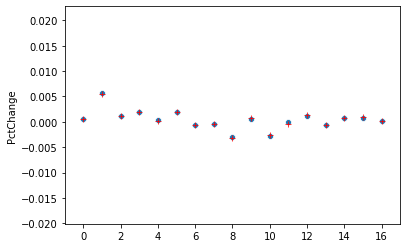

In [45]:
predef_dimensions = []
dimensions_to_sample = [x for x in X_total.columns if not x in predef_dimensions]

from pdb import set_trace as keyboard
from operator import attrgetter

N = 1000
minNumberDimensions = 6
sensitivity = .15
size_samples = np.random.randint(10-len(predef_dimensions), 13-len(predef_dimensions), size=N)

result_list = []
rsquared_ajd_list = []

X_total_model = X_total.copy()
X_total_model['Bias'] = 1.

useBias = 1

for iteration in range(N):
    
    sys.stdout.write("\rIteration number {}".format(iteration))
    sys.stdout.flush()
    
    while True:
        
        selected_dimensions = np.random.choice(dimensions_to_sample, \
                                               size=size_samples[iteration], replace=False).tolist() + predef_dimensions
        
        if useBias:
             selected_dimensions += ['Bias']

        X = X_total_model[selected_dimensions]

        regressor_OLS = sm.OLS(endog=y, exog=X.values).fit()  
        pvalues_dict = dict(zip(selected_dimensions, regressor_OLS.pvalues))

        try:
        
            while max(list(pvalues_dict.values())) > sensitivity:
                dimensions_bigPvalue = \
                            list({ key:value for (key,value) in pvalues_dict.items() if value > sensitivity}.keys())
                if 'Bias' in dimensions_bigPvalue:
                    dimensions_bigPvalue.remove('Bias')
                dimensionToRemove = np.random.choice(dimensions_bigPvalue)
                selected_dimensions.remove(dimensionToRemove)
                #stocks_bigPvalue.remove(stockToRemove)
                del X[dimensionToRemove]
                regressor_OLS = sm.OLS(endog=y, exog=X.values).fit()  
                pvalues_dict = dict(zip(selected_dimensions, regressor_OLS.pvalues))
                coeffs_dict  = dict(zip(selected_dimensions, regressor_OLS.params))
                if len(pvalues_dict) == minNumberDimensions:
                    break

            result_list.append(Results(regressor_OLS,
                               regressor_OLS.rsquared_adj, 
                               pvalues_dict, 
                               coeffs_dict,    
                               selected_dimensions))
        
        except:
            pass
        
        if len(pvalues_dict) > 0:
            break
                          


result_list.sort(key=lambda x: x.rsquared_adj, reverse=True)
best_rsquaredAdj_obj = result_list[0]

print('\nNumber of dimensions: %s' % len(best_rsquaredAdj_obj.selected_dimensions))
print('\nDimensions: %s' % best_rsquaredAdj_obj.selected_dimensions)
print('\nR2 adj: %s' % best_rsquaredAdj_obj.rsquared_adj)
#print('\np-values: %s' % pd.DataFrame(best_rsquaredAdj_obj.pvalues.values(), list(best_rsquaredAdj_obj.pvalues.keys())))
#print('\nParams: %s' % best_rsquaredAdj_obj.model.summary(xname=best_rsquaredAdj_obj.selected_dimensions))

fig, ax = plt.subplots()
fittedValues = X_total_model[best_rsquaredAdj_obj.selected_dimensions].multiply(best_rsquaredAdj_obj.model.params.values).sum(axis=1).values
sns.scatterplot(range(len(y)), y, ax=ax)
sns.scatterplot(range(len(fittedValues)), fittedValues, marker='+', color='red', ax=ax)

In [62]:
df_topR2 = pd.DataFrame(result_list[0].coeffs_dict.values(), list(result_list[0].coeffs_dict.keys()))
for i in range(1, len(result_list)):
    if result_list[i].rsquared_adj < .98:
        break
    p_values = pd.DataFrame(result_list[i].coeffs_dict.values(), list(result_list[i].coeffs_dict.keys()))
    df_topR2 = pd.concat((df_topR2, p_values))
    
by_row_index = df_topR2.groupby(df_topR2.index)
df_means = by_row_index.mean()

df_means

,0
Bias,-0.009371
ICON,0.171797
IEE,0.310127
LTN 010120,7.534046
LTN 010121,6.873972
LTN 010122,-4.708265
LTN 010123,2.459155
NTN-B Princ 150535,71.147064
NTN-B Princ 150545,-43.480751
UTIL,-0.366593


In [60]:
mean_fit = X_total_model[df_means.index].mul(pd.Series(df_means.to_dict()[0]), axis=1).sum(axis=1)

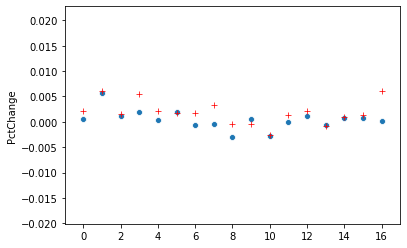

In [61]:
fig, ax = plt.subplots()
fittedValues = X_total_model[best_rsquaredAdj_obj.selected_dimensions].multiply(best_rsquaredAdj_obj.model.params.values).sum(axis=1).values
sns.scatterplot(range(len(y)), y, ax=ax)
sns.scatterplot(range(len(mean_fit)), mean_fit, marker='+', color='red', ax=ax)

In [ ]:
y

In [ ]:
best_rsquaredAdj_obj = result_list[100]

print('\nNumber of dimensions: %s' % len(best_rsquaredAdj_obj.selected_dimensions))
print('\nDimensions: %s' % best_rsquaredAdj_obj.selected_dimensions)
print('\nR2 adj: %s' % best_rsquaredAdj_obj.rsquared_adj)
print('\np-values: %s' % pd.DataFrame(best_rsquaredAdj_obj.pvalues.values(), list(best_rsquaredAdj_obj.pvalues.keys())))
print('\nParams: %s' % best_rsquaredAdj_obj.model.summary(xname=best_rsquaredAdj_obj.selected_dimensions))

fig, ax = plt.subplots()
fittedValues = X_total_model[best_rsquaredAdj_obj.selected_dimensions].multiply(best_rsquaredAdj_obj.model.params.values).sum(axis=1).values
sns.scatterplot(range(len(y)), y, ax=ax)
sns.scatterplot(range(len(fittedValues)), fittedValues, marker='+', color='red', ax=ax)